# New York City Taxi Fare Prediction

Este projeto está dividido em 5 diferentes notebooks:

- **1 - Procurando erros**: aqui vamos dar uma olhada nos possíveis valores das variáveis, procurando inconsistências e pensando em planos para correções desse problemas.

- **2 - Dataset Shift**: a ideia é estudar fenômenos temporais que podem estar ocorrendo e definir estratégias para abordar essa questão.

- **3 - Pré-processamento, modelagem e validação**: neste momento vamos ajustar os problemas encontrados anteriormente além de criar novas variáveis relevantes ao contexto. além disso iremos fazer uma otimização de hiperparâmetros, escolhendo uma métrica adequada ao nosso problema.

- **Apêndice - Zipcode knn**: Utilizando uma API vamos, a partir da latitude/longitude, encontrar o endereço da localização e ter acesso à algumas informações como o CEP. Essa consulta é operacionalmente custosa e portanto criamos um pequeno modelo para que possamos preencher os valores das localizações que não foram consultadas. 

- **Apêndice - GMaps**: Aqui, temos apenas um pequeno notebook para plotar os dados de latitude/longitude no Google Maps.

# 1 - Procurando erros

## 1.1 - Baixando e importando dados

In [1]:
# baixando o dataset para utilizar no ambiente Google Colab
!gdown --id 1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv

Downloading...
From: https://drive.google.com/uc?id=1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv
To: /content/train.csv.zip
1.67GB [00:17, 98.0MB/s]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('train.csv.zip', compression='zip', nrows=5000000,
                   error_bad_lines=False).drop(columns='key')

print(df.shape)
print(df.columns)

(5000000, 7)
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')


Vamos separar o dataset de treino do dataset do teste desde o início para não vazar particularidades.

In [4]:
df_train, df_test, _, _ = train_test_split(df, df.index, test_size=0.2, random_state=42)

## 1.2 - Funções auxiliares para procurar erros variável por variável

In [5]:
# funções auxiliares para olhar variáveis individualmente

def eda(df, variavel):
  print('número de linhas', df.shape[0], end='\n\n')
  print(df[variavel].describe(percentiles = [0.1, 0.5, 0.9])[['min', '10%', '50%', '90%', 'max', 'mean', 'std']], end='\n\n')
  print('porcentagem de valores missing:', df[variavel].isna().sum()/df.shape[0], end='\n\n')
  print('porcentagem de valores únicos:', df[variavel].nunique()/df.shape[0], end='\n\n')
  print('valores mais frequentes:',df[variavel].value_counts().head(10), sep='\n', end='\n\n')

def hist(df, variavel, quantile_inf=False, quantile_sup=False, bins=30):
  if quantile_inf or quantile_sup:
    qi = np.quantile(df[variavel], quantile_inf)
    qs = np.quantile(df[variavel], quantile_sup)
    plt.hist(df[variavel], range=(qi,qs), bins=bins)
  else:
    plt.hist(df[variavel], bins=bins)

## 1.3 Fare_amount

número de linhas 4000000

min     -100.000000
10%        4.500000
50%        8.500000
90%       20.500000
max     1273.310000
mean      11.343988
std        9.813994
Name: fare_amount, dtype: float64

porcentagem de valores missing: 0.0

porcentagem de valores únicos: 0.00092175

valores mais frequentes:
6.5     194485
4.5     164295
8.5     150134
5.3     117051
5.7     116998
4.9     113309
6.1     113303
6.9     104456
10.5    101504
7.3      98100
Name: fare_amount, dtype: int64



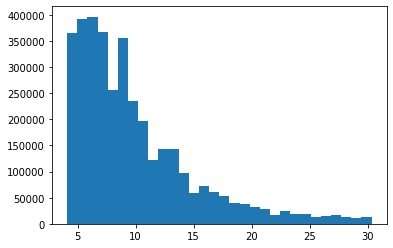

In [6]:
eda(df_train, "fare_amount")
hist(df_train, "fare_amount", 0.05, 0.95)

- os valores negativos parecem ser algum tipo de reembolso. vou assumir que estão corretos

- temos alguns valores muito grandes da target que, no treino, vou clipar para ter um máximo. claro que isso vai depender da aplicação do meu modelo, mas pensando que a viagem é dentro de nova york, dificilmente o valor vai ser muito grande.

In [7]:
# apena 0.1% da base tem valor acima de:
np.quantile(df_train['fare_amount'], 0.999)

80.0

## 1.4 Pickup_longitude

número de linhas 4000000

min    -3426.608950
10%      -74.002777
50%      -73.981807
90%      -73.950745
max     2857.839645
mean     -72.505054
std       12.639636
Name: pickup_longitude, dtype: float64

porcentagem de valores missing: 0.0

porcentagem de valores únicos: 0.0406335

valores mais frequentes:
 0.000000     76333
-73.137393     1303
-73.982100      323
-73.982400      317
-73.982037      311
-73.982297      309
-73.982300      300
-73.982200      300
-73.982175      297
-73.982320      294
Name: pickup_longitude, dtype: int64



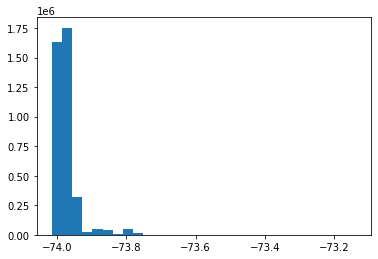

In [8]:
eda(df_train, "pickup_longitude")
hist(df_train, "pickup_longitude", 0.01, 0.98)

- aparentemente deram um fillna(0) nessa coluna

- a cidade de nova york está na região com longitude entre -74.3 e -73.5. valores fora disso parecem ser um erro.

- vou tentar, nesses valores errados, trocar a latitude com longitude e ver se isso arruma, se isso se manter pretendo substituir adicionar uma flag e substituir com a mediana.

In [9]:
#alguns casos que indicam que pode ter ocorrido uma troca
df_train.query('not -74.3<pickup_longitude<-73.5 and pickup_longitude!=0').head(3)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1140214,7.5,2013-05-24 21:46:00 UTC,40.743617,-73.992660,40.728672,-74.000230,2
1449568,19.0,2013-05-24 07:29:00 UTC,40.762567,-73.959593,40.702862,-74.012937,1
1892349,9.0,2013-05-24 08:56:00 UTC,40.708937,-74.009040,40.718402,-74.007287,1


## 1.5 Pickup_latitude

número de linhas 4000000

min    -3488.079513
10%       40.718272
50%       40.752647
90%       40.779795
max     2977.030610
mean      39.918939
std        8.878363
Name: pickup_latitude, dtype: float64

porcentagem de valores missing: 0.0

porcentagem de valores únicos: 0.0495835

valores mais frequentes:
0.000000     76103
41.366138     1303
40.774057      292
40.774100      292
40.774072      259
40.774067      258
40.774087      252
40.774102      246
40.774077      243
40.774082      242
Name: pickup_latitude, dtype: int64



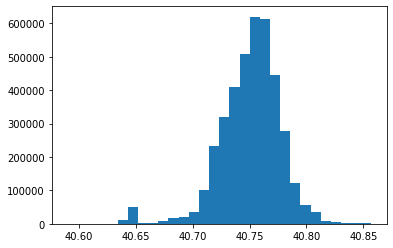

In [10]:
eda(df_train, "pickup_latitude")
hist(df_train, "pickup_latitude", 0.02, 0.999)

- aparentemente deram um fillna(0) nessa coluna

- a cidade de nova york está na região com latitude entre 40.3 e 41.2. valores fora disso parecem ser um erro.

- vou tentar, nesses valores errados, trocar a latitude com longitude e ver se isso arruma, se isso se manter pretendo substituir adicionar uma flag e substituir com a mediana.


## 1.6 Dropoff_longitude

número de linhas 4000000

min    -3412.653087
10%      -74.002903
50%      -73.980157
90%      -73.945522
max     3457.622350
mean     -72.506863
std       12.952544
Name: dropoff_longitude, dtype: float64

porcentagem de valores missing: 7.25e-06

porcentagem de valores únicos: 0.05173425

valores mais frequentes:
 0.000000     76129
-73.137393      988
-73.982400      293
-73.982200      269
-73.982300      252
-73.990800      249
-73.982100      248
-73.981800      244
-73.991700      243
-73.982297      238
Name: dropoff_longitude, dtype: int64



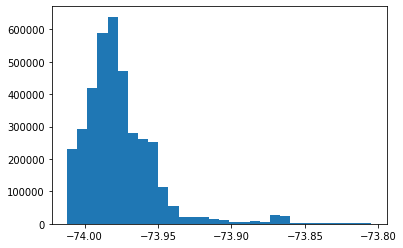

In [11]:
eda(df_train, "dropoff_longitude")
hist(df_train.fillna(0), "dropoff_longitude", 0.02, 0.97)

aparentemente deram um fillna(0) nessa coluna, mas sobrou alguns poucos missing. vou fillar com 0 já que não parece ter nenhum padrão, como vemos abaixo

a cidade de nova york está na região com longitude entre -74.3 e -73.5. valores fora disso parecem ser um erro.

vou tentar, nesses valores errados, trocar a latitude com longitude e ver se isso arruma, se isso se manter pretendo substituir adicionar uma flag e substituir com a mediana.

In [12]:
df_train[df_train.isna().any(axis=1)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4835072,37.00,2013-11-05 06:31:08 UTC,-73.989500,40.774898,NaN,NaN,0
2664981,6.00,2012-12-11 13:44:45 UTC,-73.970775,40.758842,NaN,NaN,0
580338,21.00,2012-12-11 12:00:53 UTC,-73.974743,40.752057,NaN,NaN,0
3700567,6.00,2013-11-13 10:53:50 UTC,-73.971869,40.792019,NaN,NaN,0
4165644,22.20,2012-10-09 18:08:15 UTC,-73.989235,40.773458,NaN,NaN,0
1521628,28.00,2012-12-11 13:32:14 UTC,-73.952428,40.792340,NaN,NaN,0
2455721,18.10,2013-12-08 02:27:17 UTC,-74.003022,40.731176,NaN,NaN,0
524834,14.76,2011-09-25 23:01:12 UTC,-73.985374,40.768518,NaN,NaN,0
2087156,6.50,2012-12-11 11:25:07 UTC,-73.966860,40.769835,NaN,NaN,0
4114839,34.75,2012-07-18 13:59:42 UTC,-73.972758,40.752950,NaN,NaN,0


## 1.7 Dropoff_latitude

número de linhas 4000000

min    -3488.079513
10%       40.713350
50%       40.753150
90%       40.782792
max     3305.291182
mean      39.912430
std        9.451773
Name: dropoff_latitude, dtype: float64

porcentagem de valores missing: 7.25e-06

porcentagem de valores únicos: 0.063574

valores mais frequentes:
0.000000     75914
41.366138      988
40.761200      220
40.758242      216
40.750000      212
40.759200      210
40.750300      204
40.760700      201
40.750100      198
40.750400      196
Name: dropoff_latitude, dtype: int64



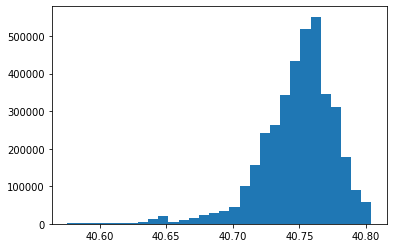

In [13]:
eda(df_train, "dropoff_latitude")
hist(df_train.fillna(0), "dropoff_latitude", 0.02, 0.97)

aparentemente deram um fillna(0) nessa coluna, mas sobrou alguns poucos missing. vou fillar com 0 já que não parece ter nenhum padrão, como vemos abaixo

a cidade de nova york está na região com latitude entre 40.3 e 41.2. valores fora disso parecem ser um erro.

vou tentar, nesses valores errados, trocar a latitude com longitude e ver se isso arruma, se isso se manter pretendo substituir adicionar uma flag e substituir com a mediana.

## 1.8 Passenger_count

número de linhas 4000000

min       0.00000
10%       1.00000
50%       1.00000
90%       4.00000
max     208.00000
mean      1.68496
std       1.33785
Name: passenger_count, dtype: float64

porcentagem de valores missing: 0.0

porcentagem de valores únicos: 3e-06

valores mais frequentes:
1      2766737
2       590896
5       283101
3       175422
4        85061
6        84606
0        14165
208          7
9            2
129          1
Name: passenger_count, dtype: int64



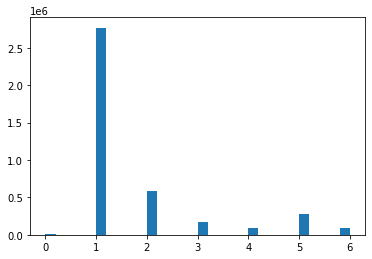

In [14]:
eda(df_train.fillna(0), "passenger_count")
hist(df_train.fillna(0), "passenger_count", 0, 0.99)

- existem modelos de carros com 6 lugares (por exemplo vans) e acho razoável manter tais valores.

- aparentemente deram um fillna(0) nessa coluna que vou manter já que esse valor  está fora do domínio e pretendo usar árvores que podem isolar tais exemplos.

- mesma ideia para esse 208 que aparece e está fora do range(1,7).

## 1.9 Considerações finais

- na maioria das variáveis, 99% da base está satisfazendo condições desejadas. vamos criar o fluxo de ajuste simplesmente porque esses problemas podem ocorrer "em produção" e é razoável ter o fluxo preparado pra esses exemplos.

- falta analisar o pickup_datetime, que vou deixar separado para o segundo notebook, em que vamos analisar dinâmicas temporais.